# Draft_01_v6

**Course:** Advanced Topics in Deep Learning  
**Topic:** Generative Adversarial Networks (GANs)  
**Authors:** António Cruz (140129), Cátia Brás (), Ricardo Kayseller (95813)

## 1. Environment Setup

---

In [1]:
# Import required dependencies
import os
import time
import numpy as np
from copy import deepcopy
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch import Tensor
from torch.nn.utils import spectral_norm

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance

In [2]:
# Global variables

SEED = 42

LIVE_MONITOR = False
EMIT_INTERVAL = 1

DATASET_PATH = "../../dataset/"

BATCH_SIZE = 128
LATENT_DIM = 100
NUM_CLASSES = 10

NUM_STEPS = 15005
SAVE_INTERVAL = 1000

# Loss function strategy: "bce", "lsgan", "hinge", "wgan-gp"
LOSS_STRATEGY = "wgan-gp"

# TTUR: Two Time-Scale Update Rule
# D learns faster than G, so we use different learning rates
LR_D = 4e-4  # Discriminator learning rate
LR_G = 1e-4  # Generator learning rate (4x slower)

# Adam betas optimized for GAN training
# Lower β1 (0.5 vs default 0.9) reduces momentum, stabilizes adversarial updates
ADAM_BETAS = (0.5, 0.999)

# Label smoothing for BCE/LSGAN (use 0.9 instead of 1.0 for real labels)
LABEL_SMOOTHING_REAL = 0.9

# WGAN-GP: number of critic steps per generator step
N_CRITIC = 5

MODEL_OUTPUT_PATH = "model/"
D_MODEL_NAME = "D_DRAFT_01"
G_MODEL_NAME = "G_DRAFT_01"

NUM_EVAL_SAMPLES = 10000

# Strategies to benchmark
BENCHMARK_STRATEGIES = ["bce", "lsgan", "hinge", "wgan-gp"]

In [3]:
if LIVE_MONITOR:
    from bin.gan_monitor import (
        start_server, emit_frames, emit_done,
        emit_benchmark_start, emit_strategy_start, emit_strategy_end
    )
    start_server(port=8992)

In [4]:
# Set random seeds for reproducibility across both numpy and pytorch
np.random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
# Use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Loss Strategies

class GANLossStrategy(ABC):
    """Base class for GAN loss strategies."""
    use_sigmoid: bool = True
    use_label_smoothing: bool = False  # only BCE/LSGAN use this
    n_critic: int = 1  # D steps per G step
    smooth_real: float = 1.0
    
    @abstractmethod
    def d_loss_real(self, output: Tensor) -> Tensor:
        """Discriminator loss for real images."""
        pass
    
    @abstractmethod
    def d_loss_fake(self, output: Tensor) -> Tensor:
        """Discriminator loss for fake images."""
        pass
    
    @abstractmethod
    def g_loss(self, output: Tensor) -> Tensor:
        """Generator loss."""
        pass
    
    def gradient_penalty(self, real_imgs: Tensor, fake_imgs: Tensor, labels: Tensor) -> Tensor:
        """Gradient penalty (only used by WGAN-GP)."""
        return torch.tensor(0.0, device=real_imgs.device)
    
    def set_d_model(self, d_model) -> None:
        """Set discriminator reference (used by WGAN-GP)."""
        pass
    
    def compute_d_loss(self, d_loss_real: Tensor, d_loss_fake: Tensor, gp: Tensor) -> Tensor:
        """Combine D losses. Override for strategy-specific formulas."""
        return 0.5 * (d_loss_real + d_loss_fake) + gp


class BCELossStrategy(GANLossStrategy):
    """Binary Cross-Entropy loss (original GAN) with label smoothing."""
    use_sigmoid = True
    use_label_smoothing = True
    
    def __init__(self, device, smooth_real: float = 0.9):
        self.device = device
        self.criterion = nn.BCELoss()
        self.smooth_real = smooth_real
        self._real_labels = None
        self._fake_labels = None
    
    def _ensure_labels(self, batch_size):
        if self._real_labels is None or self._real_labels.size(0) != batch_size:
            self._real_labels = torch.full((batch_size, 1), self.smooth_real, device=self.device)
            self._fake_labels = torch.zeros(batch_size, 1, device=self.device)
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._real_labels)
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._fake_labels)
    
    def g_loss(self, output: Tensor) -> Tensor:
        # G wants D to output 1.0 (no smoothing for G)
        ones = torch.ones(output.size(0), 1, device=self.device)
        return self.criterion(output, ones)


class LSGANLossStrategy(GANLossStrategy):
    """Least Squares loss with label smoothing."""
    use_sigmoid = False
    use_label_smoothing = True
    
    def __init__(self, device, smooth_real: float = 0.9):
        self.device = device
        self.criterion = nn.MSELoss()
        self.smooth_real = smooth_real
        self._real_labels = None
        self._fake_labels = None
    
    def _ensure_labels(self, batch_size):
        if self._real_labels is None or self._real_labels.size(0) != batch_size:
            self._real_labels = torch.full((batch_size, 1), self.smooth_real, device=self.device)
            self._fake_labels = torch.zeros(batch_size, 1, device=self.device)
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._real_labels)
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._fake_labels)
    
    def g_loss(self, output: Tensor) -> Tensor:
        ones = torch.ones(output.size(0), 1, device=self.device)
        return self.criterion(output, ones)


class HingeLossStrategy(GANLossStrategy):
    """Hinge loss — used in SAGAN, BigGAN."""
    use_sigmoid = False
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        return torch.mean(F.relu(1.0 - output))
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        return torch.mean(F.relu(1.0 + output))
    
    def g_loss(self, output: Tensor) -> Tensor:
        return -torch.mean(output)


class WGANGPLossStrategy(GANLossStrategy):
    """Wasserstein loss with gradient penalty."""
    use_sigmoid = False
    n_critic = 5  # train D 5 times per G step
    
    def __init__(self, lambda_gp: float = 10.0):
        self.d_model = None
        self.lambda_gp = lambda_gp
    
    def set_d_model(self, d_model) -> None:
        self.d_model = d_model
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        return -torch.mean(output)
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        return torch.mean(output)
    
    def g_loss(self, output: Tensor) -> Tensor:
        return -torch.mean(output)
    
    def gradient_penalty(self, real_imgs: Tensor, fake_imgs: Tensor, labels: Tensor) -> Tensor:
        if self.d_model is None:
            raise RuntimeError("d_model not set. Call set_d_model() first.")
        
        batch_size = real_imgs.size(0)
        
        alpha = torch.rand(batch_size, 1, 1, 1, device=real_imgs.device)
        interpolated = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)
        
        d_out = self.d_model(interpolated, labels)
        
        gradients = torch.autograd.grad(
            outputs=d_out,
            inputs=interpolated,
            grad_outputs=torch.ones_like(d_out),
            create_graph=True,
            retain_graph=True,
        )[0]
        
        gradients = gradients.view(batch_size, -1)
        gradient_norm = gradients.norm(2, dim=1)
        
        return self.lambda_gp * ((gradient_norm - 1) ** 2).mean()
    
    def compute_d_loss(self, d_loss_real: Tensor, d_loss_fake: Tensor, gp: Tensor) -> Tensor:
        """WGAN-GP uses d_fake - d_real + gp (no 0.5 averaging)."""
        return d_loss_fake + d_loss_real + gp  # note: d_loss_real is already negated


def get_loss_strategy(name: str, device) -> GANLossStrategy:
    """Factory function to get loss strategy by name."""
    strategies = {
        "bce": BCELossStrategy,
        "lsgan": LSGANLossStrategy,
        "hinge": HingeLossStrategy,
        "wgan-gp": WGANGPLossStrategy,
    }
    if name not in strategies:
        raise ValueError(f"Unknown loss strategy: {name}. Options: {list(strategies.keys())}")
    
    if name == "bce":
        return strategies[name](device, smooth_real=LABEL_SMOOTHING_REAL)
    if name == "lsgan":
        return strategies[name](device, smooth_real=LABEL_SMOOTHING_REAL)
    return strategies[name]()

## 2. Data Loading

---

In [7]:
# Transform: convert PIL image to tensor (scales [0,255] to [0,1]),
# then normalize to [-1, 1] range using mean=0.5, std=0.5
# Formula: (x - 0.5) / 0.5 = 2x - 1, which maps [0,1] to [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset from a local folder
train_dataset = datasets.MNIST(
    root=DATASET_PATH,
    train=True,
    download=False,
    transform=transform
)

# DataLoader handles batching, shuffling, and parallel loading
# drop_last=True discards the final incomplete batch so every batch has exactly BATCH_SIZE samples
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

print(f"Training samples: {len(train_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

Training samples: 60000
Batches per epoch: 468


## 3. Generator

---

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, num_classes=NUM_CLASSES):
        super().__init__()
        self.label_embedding = nn.Embedding(num_classes, latent_dim)

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(),
        )

        # Block 1: 7x7 -> 14x14
        self.conv1 = nn.Conv2d(128, 128 * 4, kernel_size=3, padding=1)
        self.ps1 = nn.PixelShuffle(2)
        self.bn1 = nn.BatchNorm2d(128, momentum=0.8)

        # Block 2: 14x14 -> 28x28
        self.conv2 = nn.Conv2d(128, 64 * 4, kernel_size=3, padding=1)
        self.ps2 = nn.PixelShuffle(2)
        self.bn2 = nn.BatchNorm2d(64, momentum=0.8)

        self.output_conv = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        
        self.apply(self._init_weights)
        self._icnr_init(self.conv1, upscale_factor=2)
        self._icnr_init(self.conv2, upscale_factor=2)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.zeros_(m.bias)

    def _icnr_init(self, conv_layer, upscale_factor):
        """Specialized initialization to prevent checkerboard/dots."""
        new_shape = [
            conv_layer.out_channels // (upscale_factor**2),
            conv_layer.in_channels,
            conv_layer.kernel_size[0],
            conv_layer.kernel_size[1]
        ]
        sub_kernel = torch.randn(new_shape) * 0.02
        # Repeat the sub-kernel across the 'sub-pixel' channels
        # This makes all 4 pixels in a 2x2 block start identical
        icnr_kernel = sub_kernel.repeat_interleave(upscale_factor**2, dim=0)
        conv_layer.weight.data.copy_(icnr_kernel)

    def forward(self, z, labels):
        label_embed = self.label_embedding(labels)  # labels shape: [B]
        x = self.fc(z * label_embed)
        x = x.view(-1, 128, 7, 7)

        x = F.relu(self.bn1(self.ps1(self.conv1(x))))
        x = F.relu(self.bn2(self.ps2(self.conv2(x))))
        return torch.tanh(self.output_conv(x))


# Instantiate and move to device
g_model = Generator().to(device)
print(g_model)

Generator(
  (label_embedding): Embedding(10, 100)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): ReLU()
  )
  (conv1): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ps1): PixelShuffle(upscale_factor=2)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ps2): PixelShuffle(upscale_factor=2)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (output_conv): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## 4. Discriminator

---

In [9]:
class Discriminator(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES, use_sigmoid=True):
        super().__init__()
        
        self.use_sigmoid = use_sigmoid

        # Embed the class label into a vector of size 28*28
        self.label_embedding = nn.Embedding(num_classes, 28 * 28)

        # Main sequential network with Spectral Normalization
        self.model = nn.Sequential(
            # Input is (2, 28, 28): image channel + label channel
            spectral_norm(nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            # Second conv block: (32, 14, 14) → (64, 7, 7)
            spectral_norm(nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            # Flatten
            nn.Flatten(),

            # Dense layers with Spectral Normalization
            spectral_norm(nn.Linear(64 * 7 * 7, 512)),
            nn.ReLU(),
            nn.Dropout(0.25),

            spectral_norm(nn.Linear(512, 1)),
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        
        # Embed label and reshape to spatial map
        label_embed = self.label_embedding(labels)  # labels shape: [B] -> [B, 784]
        label_embed = label_embed.view(batch_size, 1, 28, 28)

        # Concatenate image and label map
        x = torch.cat([img, label_embed], dim=1)

        x = self.model(x)
        
        if self.use_sigmoid:
            x = torch.sigmoid(x)
        
        return x

In [10]:
def weights_init(m):
    """
    DCGAN-style weight initialization.
    Skip spectral_norm wrapped layers (they handle their own init).
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 and not hasattr(m, 'weight_orig'):
        # Conv layer without spectral norm
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif classname.find('Linear') != -1 and not hasattr(m, 'weight_orig'):
        # Linear layer without spectral norm
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, mean=1.0, std=0.02)
        nn.init.zeros_(m.bias)
    elif classname.find('Embedding') != -1:
        nn.init.normal_(m.weight, mean=0.0, std=0.02)

# 5. Loss and Optimizers

---

In [11]:
# Instantiate models - get strategy first to use its use_sigmoid
g_model = Generator().to(device)  # has its own init
loss_strategy = get_loss_strategy(LOSS_STRATEGY, device)
d_model = Discriminator(use_sigmoid=loss_strategy.use_sigmoid).to(device)

# Apply DCGAN weight initialization only to D
d_model.apply(weights_init)
print("Applied DCGAN weight initialization to Discriminator")

loss_strategy.set_d_model(d_model)
print(f"Using loss strategy: {LOSS_STRATEGY}")
print(f"  - use_sigmoid: {loss_strategy.use_sigmoid}")
print(f"  - n_critic: {loss_strategy.n_critic}")
if loss_strategy.use_label_smoothing:
    print(f"  - label_smoothing: {loss_strategy.smooth_real}")

# Optimizers with TTUR
optimizer_d = optim.Adam(d_model.parameters(), lr=LR_D, betas=ADAM_BETAS)
optimizer_g = optim.Adam(g_model.parameters(), lr=LR_G, betas=ADAM_BETAS)
print(f"TTUR: LR_D={LR_D}, LR_G={LR_G}, betas={ADAM_BETAS}")

Applied DCGAN weight initialization to Discriminator
Using loss strategy: wgan-gp
  - use_sigmoid: False
  - n_critic: 5
TTUR: LR_D=0.0004, LR_G=0.0001, betas=(0.5, 0.999)


# 6. Training

---

In [12]:
# =============================================================================
# Class-Consistency Evaluation
# =============================================================================
# Measures % of generated images where classifier prediction matches conditioned label.
# Uses the same calibrated classifier from the game for consistency.

# Classifier architecture (must match checkpoint)
class MNISTCNNCalibrated(nn.Module):
    """Calibrated CNN for MNIST - architecture only, no Lightning dependencies."""
    
    def __init__(self, width=128, depth=3, dropout_p=0.1, num_classes=10):
        super().__init__()
        
        # Encoder: depth blocks of Conv(3x3) -> ReLU -> MaxPool(2)
        channels = [width, 2 * width, 2 * width][:depth]
        in_ch = 1
        blocks = []
        for out_ch in channels:
            blocks.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=True))
            blocks.append(nn.ReLU())
            blocks.append(nn.MaxPool2d(kernel_size=2))
            in_ch = out_ch
        self.encoder = nn.Sequential(*blocks)
        
        # Head: flatten -> FC(width) -> ReLU -> dropout -> FC(num_classes)
        spatial = 28 // (2 ** depth)
        feat_dim = channels[-1] * spatial * spatial
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim, width),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(width, num_classes),
        )
    
    def forward(self, x):
        return self.head(self.encoder(x))


def load_calibrated_classifier(checkpoint_path):
    """Load the calibrated classifier from checkpoint."""
    classifier = MNISTCNNCalibrated(width=128, depth=3, dropout_p=0.1)
    
    # Load checkpoint (Lightning format)
    ckpt = torch.load(checkpoint_path, map_location=device, weights_only=False)
    state_dict = ckpt['state_dict']
    
    # Remove 'model.' prefix if present (Lightning adds this sometimes)
    clean_state = {}
    for k, v in state_dict.items():
        clean_key = k.replace('model.', '') if k.startswith('model.') else k
        clean_state[clean_key] = v
    
    classifier.load_state_dict(clean_state)
    classifier.to(device)
    classifier.eval()
    return classifier


def evaluate_class_consistency(g_model, classifier, samples_per_class=500):
    """
    Evaluate class-consistency accuracy.
    
    Returns:
        overall_accuracy: % of generated images where prediction matches conditioned label
        per_class_accuracy: List of accuracies for each digit (0-9)
    """
    classifier.eval()
    g_model.eval()
    
    correct = 0
    total = 0
    per_class_correct = [0] * 10
    per_class_total = [0] * 10
    
    with torch.no_grad():
        for digit in range(10):
            labels = torch.full((samples_per_class,), digit, device=device).long()
            noise = torch.randn(samples_per_class, LATENT_DIM, device=device)
            
            # Generate images (output range: [-1, 1])
            fake_imgs = g_model(noise, labels)
            
            # Convert to classifier input range [0, 1]
            fake_imgs_normalized = (fake_imgs + 1) / 2
            
            # Classify
            logits = classifier(fake_imgs_normalized)
            predicted = logits.argmax(dim=1)
            
            # Count matches
            matches = (predicted == labels).sum().item()
            correct += matches
            total += samples_per_class
            per_class_correct[digit] = matches
            per_class_total[digit] = samples_per_class
    
    overall_accuracy = 100.0 * correct / total
    per_class_accuracy = [100.0 * per_class_correct[i] / per_class_total[i] for i in range(10)]
    
    return overall_accuracy, per_class_accuracy


# Path to calibrated classifier checkpoint
CLASSIFIER_CHECKPOINT = "../../drafts/draft_01/classifier/mnist_cnn_calibrated_best.ckpt"

# Load classifier
print("Loading calibrated classifier for class-consistency evaluation...")
try:
    mnist_classifier = load_calibrated_classifier(CLASSIFIER_CHECKPOINT)
    print(f"Classifier loaded from: {CLASSIFIER_CHECKPOINT}")
    
    # Verify classifier accuracy on real MNIST
    classifier_correct = 0
    classifier_total = 0
    with torch.no_grad():
        for imgs, labels in train_loader:
            # Note: train_loader images are [-1, 1], convert to [0, 1]
            imgs = ((imgs + 1) / 2).to(device)
            labels = labels.to(device)
            logits = mnist_classifier(imgs)
            predicted = logits.argmax(dim=1)
            classifier_total += labels.size(0)
            classifier_correct += (predicted == labels).sum().item()
    print(f"Classifier accuracy on real MNIST: {100.0 * classifier_correct / classifier_total:.2f}%")
    CLASSIFIER_AVAILABLE = True
except FileNotFoundError:
    print(f"WARNING: Classifier checkpoint not found at {CLASSIFIER_CHECKPOINT}")
    print("Class-consistency evaluation will be skipped.")
    mnist_classifier = None
    CLASSIFIER_AVAILABLE = False


Loading calibrated classifier for class-consistency evaluation...
Classifier loaded from: ../../drafts/draft_01/classifier/mnist_cnn_calibrated_best.ckpt
Classifier accuracy on real MNIST: 99.83%


In [13]:
# Benchmark training loop

# Store results
benchmark_results = {}

def run_benchmark(strategies=BENCHMARK_STRATEGIES, num_steps=NUM_STEPS, save_interval=SAVE_INTERVAL):
    """
    Run training for each loss strategy and collect metrics.
    """
    results = {}
    
    # Emit benchmark start
    if LIVE_MONITOR:
        emit_benchmark_start(strategies, num_steps)
    
    for strategy_idx, strategy_name in enumerate(strategies):
        print(f"\n{'='*60}")
        print(f"TRAINING: {strategy_name.upper()}")
        print(f"{'='*60}\n")
        
        # Emit strategy start
        if LIVE_MONITOR:
            emit_strategy_start(strategy_name, strategy_idx, len(strategies))
        
        # Reset random seeds for fair comparison
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        
        # Instantiate fresh models - get strategy first to use its use_sigmoid
        g_model = Generator().to(device)
        loss_strategy = get_loss_strategy(strategy_name, device)
        d_model = Discriminator(use_sigmoid=loss_strategy.use_sigmoid).to(device)
        d_model.apply(weights_init)
        loss_strategy.set_d_model(d_model)
        
        # Optimizers
        optimizer_d = optim.Adam(d_model.parameters(), lr=LR_D, betas=ADAM_BETAS)
        optimizer_g = optim.Adam(g_model.parameters(), lr=LR_G, betas=ADAM_BETAS)
        
        # Training state
        losses = {"G": [], "D": []}
        data_iter = iter(train_loader)
        n_critic = loss_strategy.n_critic
        d_loss = torch.tensor(0.0)
        
        # Fixed test samples for visualization
        samples_test = torch.randn(16, LATENT_DIM, device=device)
        # Balanced labels for monitoring (0-9, 0-5) ensures all digits represented
        labels_test = torch.arange(0, 10, device=device).repeat(2)[:16].long()  # shape: [B]
        
        # Timing
        start_time = time.time()
        
        for step in range(num_steps):
            # --- Train Discriminator ---
            for _ in range(n_critic):
                try:
                    real_imgs, batch_labels = next(data_iter)
                except StopIteration:
                    data_iter = iter(train_loader)
                    real_imgs, batch_labels = next(data_iter)

                real_imgs = real_imgs.to(device)
                batch_labels = batch_labels.to(device).long()  # shape: [B]

                noise = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
                fake_imgs = g_model(noise, batch_labels)

                optimizer_d.zero_grad()
                d_real_out = d_model(real_imgs, batch_labels)
                d_loss_real = loss_strategy.d_loss_real(d_real_out)
                d_fake_out = d_model(fake_imgs.detach(), batch_labels)
                d_loss_fake = loss_strategy.d_loss_fake(d_fake_out)
                gp = loss_strategy.gradient_penalty(real_imgs, fake_imgs.detach(), batch_labels)
                d_loss = loss_strategy.compute_d_loss(d_loss_real, d_loss_fake, gp)
                d_loss.backward()
                optimizer_d.step()

            # --- Train Generator ---
            optimizer_g.zero_grad()
            z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
            gen_labels = torch.randint(0, 10, (BATCH_SIZE,), device=device).long()  # shape: [B]
            gen_imgs = g_model(z, gen_labels)
            g_out = d_model(gen_imgs, gen_labels)
            g_loss = loss_strategy.g_loss(g_out)
            g_loss.backward()
            optimizer_g.step()

            losses["G"].append(g_loss.item())
            losses["D"].append(d_loss.item())

            if step % save_interval == 0:
                print(f"Step {step} — D: {d_loss.item():.4f}, G: {g_loss.item():.4f}")

            # Live monitor
            if LIVE_MONITOR and step % EMIT_INTERVAL == 0:
                with torch.no_grad():
                    monitor_samples = g_model(samples_test, labels_test)
                emit_frames(monitor_samples, labels_test, step, g_loss.item(), d_loss.item(), num_steps)
        
        training_time = time.time() - start_time
        
        # Evaluate
        print(f"\nEvaluating {strategy_name}...")
        fid_score, kid_mean, kid_std, class_acc, per_class_acc = evaluate_model_for_benchmark(g_model, mnist_classifier if CLASSIFIER_AVAILABLE else None)
        
        # Emit strategy end with results
        if LIVE_MONITOR:
            emit_strategy_end(strategy_name, fid_score, kid_mean, kid_std, training_time)
        
        # Generate final samples
        with torch.no_grad():
            final_samples = g_model(samples_test, labels_test)
        
        # Store results
        results[strategy_name] = {
            "losses": losses,
            "fid": fid_score,
            "kid_mean": kid_mean,
            "kid_std": kid_std,
            "class_consistency": class_acc,
            "per_class_consistency": per_class_acc,
            "training_time": training_time,
            "g_model_state": deepcopy(g_model.state_dict()),
            "d_model_state": deepcopy(d_model.state_dict()),
            "final_samples": final_samples.cpu(),
            "labels_test": labels_test.cpu(),
        }
        
        print(f"\n{strategy_name.upper()} Results:")
        print(f"  FID: {fid_score:.2f}")
        print(f"  KID: {kid_mean:.4f} ± {kid_std:.4f}")
        if class_acc is not None:
            print(f"  Class-Consistency: {class_acc:.2f}%")
        print(f"  Time: {training_time:.1f}s")
    
    # Emit benchmark complete
    if LIVE_MONITOR:
        emit_done()
    
    return results


def evaluate_model_for_benchmark(g_model, classifier=None):
    """Evaluation function for benchmarking (returns values, doesn't print)."""
    fid = FrechetInceptionDistance(feature=2048).to(device)
    kid = KernelInceptionDistance(feature=2048, subset_size=100).to(device)

    idx = np.random.randint(0, len(train_dataset), NUM_EVAL_SAMPLES)
    batch_size = 256
    
    for i in range(0, NUM_EVAL_SAMPLES, batch_size):
        batch_idx = idx[i:i + batch_size]
        real_batch = torch.stack([train_dataset[j][0] for j in batch_idx])
        real_batch = ((real_batch + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)
        real_batch = real_batch.repeat(1, 3, 1, 1)
        real_batch = torch.nn.functional.interpolate(
            real_batch.float(), size=(299, 299), mode='bilinear', align_corners=False
        ).to(torch.uint8).to(device)
        fid.update(real_batch, real=True)
        kid.update(real_batch, real=True)

    for i in range(0, NUM_EVAL_SAMPLES, batch_size):
        current_batch = min(batch_size, NUM_EVAL_SAMPLES - i)
        noise = torch.randn(current_batch, LATENT_DIM, device=device)
        labels = torch.randint(0, 10, (current_batch,), device=device).long()  # shape: [B]
        with torch.no_grad():
            fake_batch = g_model(noise, labels)
        fake_batch = ((fake_batch + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)
        fake_batch = fake_batch.repeat(1, 3, 1, 1)
        fake_batch = torch.nn.functional.interpolate(
            fake_batch.float(), size=(299, 299), mode='bilinear', align_corners=False
        ).to(torch.uint8).to(device)
        fid.update(fake_batch, real=False)
        kid.update(fake_batch, real=False)

    fid_score = fid.compute().item()
    kid_mean, kid_std = kid.compute()
    
    # Class-consistency evaluation
    if classifier is not None:
        class_acc, per_class_acc = evaluate_class_consistency(g_model, classifier)
    else:
        class_acc, per_class_acc = None, None
    
    return fid_score, kid_mean.item(), kid_std.item(), class_acc, per_class_acc


# Run the benchmark
benchmark_results = run_benchmark()


TRAINING: BCE

Step 0 — D: 0.7382, G: 0.5672
Step 1000 — D: 0.5918, G: 0.9149
Step 2000 — D: 0.6666, G: 0.9089
Step 3000 — D: 0.6704, G: 0.8238
Step 4000 — D: 0.6676, G: 0.8172
Step 5000 — D: 0.6769, G: 0.8335
Step 6000 — D: 0.6825, G: 0.7977
Step 7000 — D: 0.6818, G: 0.8054
Step 8000 — D: 0.6827, G: 0.7961
Step 9000 — D: 0.6800, G: 0.8085
Step 10000 — D: 0.6834, G: 0.7993
Step 11000 — D: 0.6811, G: 0.8393
Step 12000 — D: 0.6844, G: 0.8353
Step 13000 — D: 0.6823, G: 0.8253
Step 14000 — D: 0.6821, G: 0.7902
Step 15000 — D: 0.6865, G: 0.8433

Evaluating bce...


/home/logus/env/iscte/taap_p1/.venv_taap_p1/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



BCE Results:
  FID: 7.74
  KID: 0.0048 ± 0.0020
  Class-Consistency: 97.64%
  Time: 281.7s

TRAINING: LSGAN

Step 0 — D: 0.6588, G: 0.1829
Step 1000 — D: 0.1010, G: 0.5323
Step 2000 — D: 0.1590, G: 0.3586
Step 3000 — D: 0.1796, G: 0.3643
Step 4000 — D: 0.1799, G: 0.3412
Step 5000 — D: 0.1898, G: 0.3386
Step 6000 — D: 0.1875, G: 0.3323
Step 7000 — D: 0.1878, G: 0.3223
Step 8000 — D: 0.1947, G: 0.3384
Step 9000 — D: 0.1953, G: 0.3407
Step 10000 — D: 0.1966, G: 0.3156
Step 11000 — D: 0.1973, G: 0.3209
Step 12000 — D: 0.1926, G: 0.3211
Step 13000 — D: 0.1913, G: 0.3197
Step 14000 — D: 0.1972, G: 0.3306
Step 15000 — D: 0.1912, G: 0.3166

Evaluating lsgan...

LSGAN Results:
  FID: 6.30
  KID: 0.0034 ± 0.0017
  Class-Consistency: 97.38%
  Time: 290.2s

TRAINING: HINGE

Step 0 — D: 1.1036, G: -0.2993
Step 1000 — D: 0.7520, G: 0.3453
Step 2000 — D: 0.9368, G: -0.3489
Step 3000 — D: 0.9043, G: -0.2833
Step 4000 — D: 0.9397, G: -0.0017
Step 5000 — D: 0.9488, G: 0.3082
Step 6000 — D: 0.9585, G: -

In [14]:
# Results summary table

def print_results_table(results):
    """Print a formatted comparison table."""
    print("\n" + "="*70)
    print("BENCHMARK RESULTS SUMMARY")
    print("="*70)
    print(f"{'Strategy':<12} {'FID':>10} {'KID':>18} {'Time (s)':>12}")
    print("-"*70)
    
    # Sort by FID (best first)
    sorted_results = sorted(results.items(), key=lambda x: x[1]['fid'])
    
    for i, (name, data) in enumerate(sorted_results):
        rank = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
        kid_str = f"{data['kid_mean']:.4f} ± {data['kid_std']:.4f}"
        print(f"{rank} {name:<10} {data['fid']:>10.2f} {kid_str:>18} {data['training_time']:>12.1f}")
    
    print("="*70)
    
    # Best performer
    best = sorted_results[0]
    print(f"\n✓ Best performer: {best[0].upper()} (FID: {best[1]['fid']:.2f})")

print_results_table(benchmark_results)


BENCHMARK RESULTS SUMMARY
Strategy            FID                KID     Time (s)
----------------------------------------------------------------------
🥇 lsgan            6.30    0.0034 ± 0.0017        290.2
🥈 bce              7.74    0.0048 ± 0.0020        281.7
🥉 hinge           10.44    0.0070 ± 0.0022        285.9
   wgan-gp         68.03    0.0691 ± 0.0078       1359.9

✓ Best performer: LSGAN (FID: 6.30)


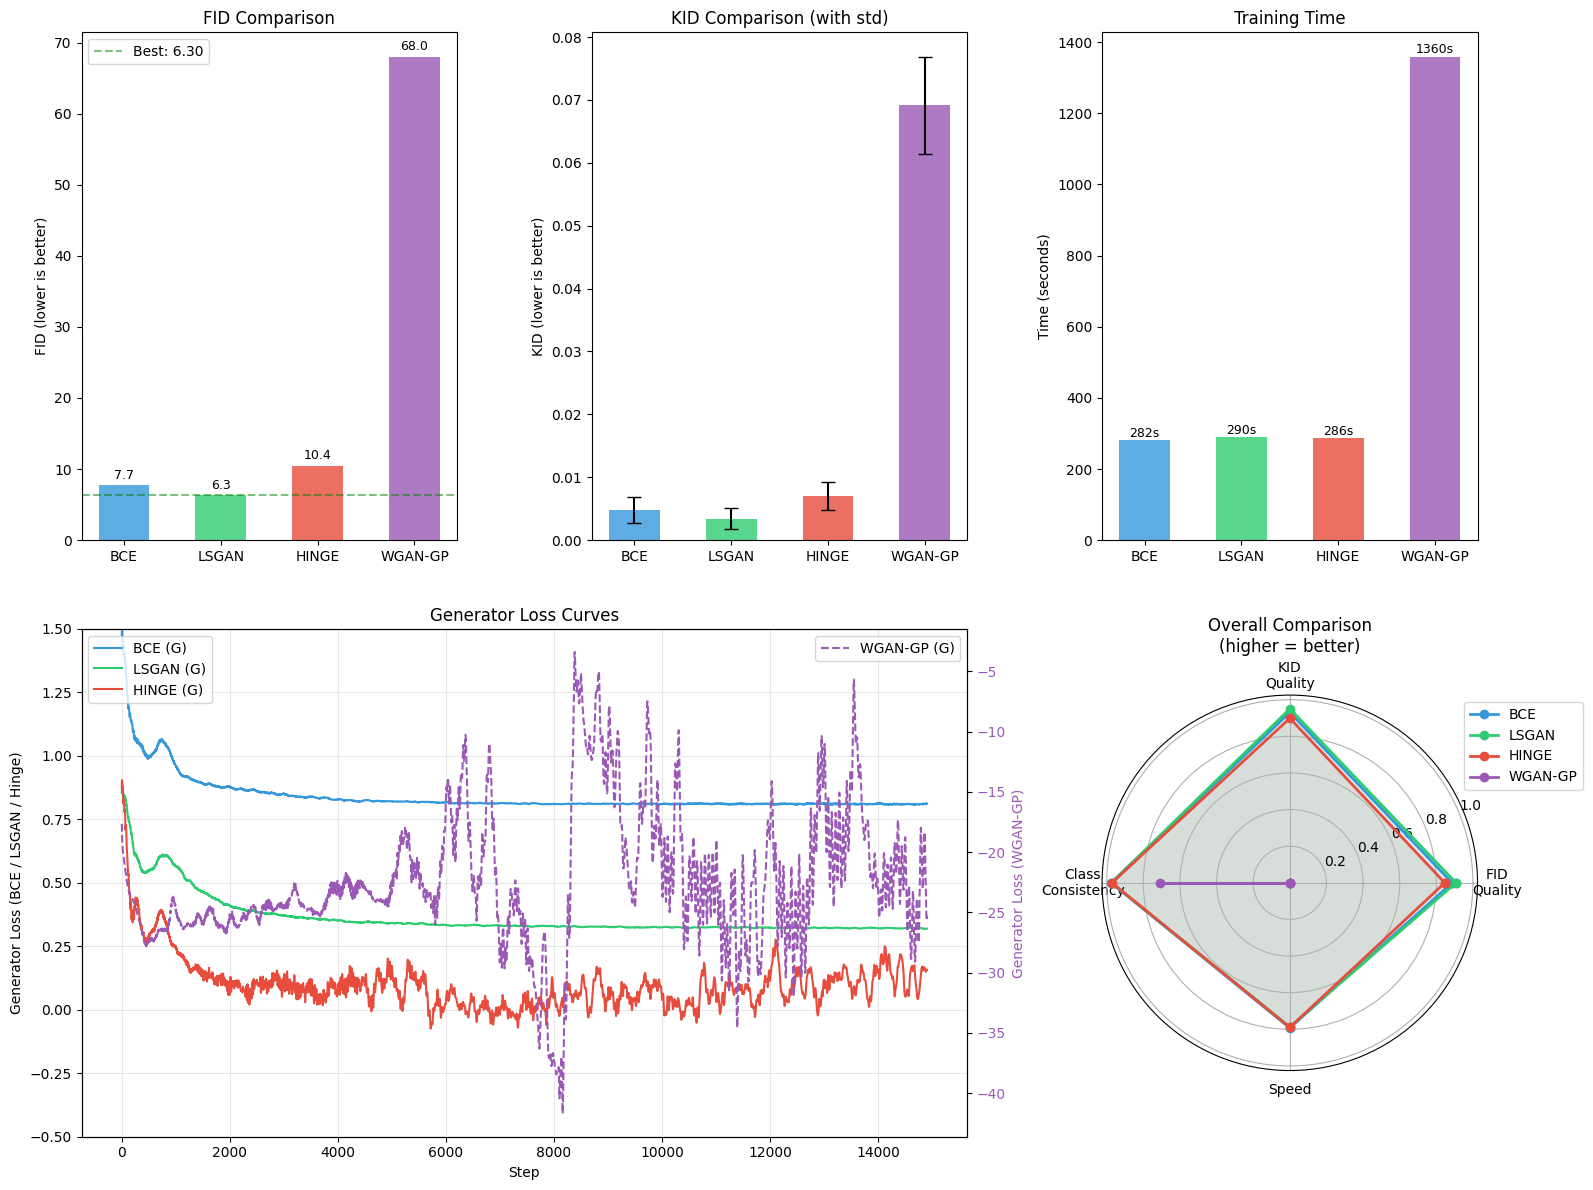

Saved: images/benchmark_comparison.png


In [23]:
# Comparison visualization

def plot_benchmark_comparison(results):
    """Create comprehensive comparison visualizations."""
    strategies = list(results.keys())
    n_strategies = len(strategies)
    
    # Color scheme
    colors = {'bce': '#3498db', 'lsgan': '#2ecc71', 'hinge': '#e74c3c', 'wgan-gp': '#9b59b6'}
    
    fig = plt.figure(figsize=(16, 12))
    
    # --- 1. FID Bar Chart (top left) ---
    ax1 = fig.add_subplot(2, 3, 1)
    x = np.arange(n_strategies)
    width = 0.35
    
    fids = [results[s]['fid'] for s in strategies]
    
    bars1 = ax1.bar(x, fids, width*1.5, color=[colors[s] for s in strategies], alpha=0.8)
    ax1.set_ylabel('FID (lower is better)')
    ax1.set_title('FID Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels([s.upper() for s in strategies])
    ax1.axhline(y=min(fids), color='green', linestyle='--', alpha=0.5, label=f'Best: {min(fids):.2f}')
    ax1.legend()
    
    for bar, val in zip(bars1, fids):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.1f}', ha='center', va='bottom', fontsize=9)
    
    # --- 2. KID Bar Chart (top middle) ---
    ax2 = fig.add_subplot(2, 3, 2)
    kid_means = [results[s]['kid_mean'] for s in strategies]
    kid_stds = [results[s]['kid_std'] for s in strategies]
    
    bars2 = ax2.bar(x, kid_means, width*1.5, yerr=kid_stds, capsize=5,
                    color=[colors[s] for s in strategies], alpha=0.8)
    ax2.set_ylabel('KID (lower is better)')
    ax2.set_title('KID Comparison (with std)')
    ax2.set_xticks(x)
    ax2.set_xticklabels([s.upper() for s in strategies])
    
    # --- 3. Training Time (top right) ---
    ax3 = fig.add_subplot(2, 3, 3)
    times = [results[s]['training_time'] for s in strategies]
    bars3 = ax3.bar(x, times, width*1.5, color=[colors[s] for s in strategies], alpha=0.8)
    ax3.set_ylabel('Time (seconds)')
    ax3.set_title('Training Time')
    ax3.set_xticks(x)
    ax3.set_xticklabels([s.upper() for s in strategies])
    
    for bar, val in zip(bars3, times):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.0f}s', ha='center', va='bottom', fontsize=9)
    
    # --- 4. Loss Curves with Dual Y-Axis (bottom left, spans 2 columns) ---
    ax4 = fig.add_subplot(2, 3, (4, 5))
    
    # Smoothing function
    def smooth(data, window=100):
        if len(data) > window:
            return np.convolve(data, np.ones(window)/window, mode='valid')
        return data
    
    # Plot BCE, LSGAN, Hinge on left axis
    for s in ['bce', 'lsgan', 'hinge']:
        if s in results:
            losses_g = results[s]['losses']['G']
            smoothed = smooth(losses_g)
            ax4.plot(smoothed, label=f'{s.upper()} (G)', color=colors[s], linewidth=1.5)
    
    ax4.set_xlabel('Step')
    ax4.set_ylabel('Generator Loss (BCE / LSGAN / Hinge)')
    ax4.set_ylim(-0.5, 1.5)
    ax4.legend(loc='upper left')
    ax4.grid(True, alpha=0.3)
    ax4.set_title('Generator Loss Curves')
    
    # Plot WGAN-GP on right axis
    if 'wgan-gp' in results:
        ax4_right = ax4.twinx()
        losses_g = results['wgan-gp']['losses']['G']
        smoothed = smooth(losses_g)
        ax4_right.plot(smoothed, label='WGAN-GP (G)', color=colors['wgan-gp'], 
                       linewidth=1.5, linestyle='--')
        ax4_right.set_ylabel('Generator Loss (WGAN-GP)', color=colors['wgan-gp'])
        ax4_right.tick_params(axis='y', labelcolor=colors['wgan-gp'])
        ax4_right.legend(loc='upper right')
    
    # --- 5. Radar/Spider Chart (bottom right) ---
    ax5 = fig.add_subplot(2, 3, 6, projection='polar')
    
    max_fid = max(fids)
    max_kid = max(kid_means)
    max_time = max(times)
    
    # Check if class-consistency is available
    has_class_consistency = all(results[s].get('class_consistency') is not None for s in strategies)
    
    if has_class_consistency:
        metrics = ['FID\nQuality', 'KID\nQuality', 'Class\nConsistency', 'Speed']
    else:
        metrics = ['FID\nQuality', 'KID\nQuality', 'Speed']
    
    n_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
    angles += angles[:1]
    
    for s in strategies:
        values = [
            1 - results[s]['fid'] / max_fid,
            1 - results[s]['kid_mean'] / max_kid,
        ]
        if has_class_consistency:
            values.append(results[s]['class_consistency'] / 100)  # normalize to 0-1
        values.append(1 - results[s]['training_time'] / max_time)
        values += values[:1]
        ax5.plot(angles, values, 'o-', linewidth=2, label=s.upper(), color=colors[s])
        ax5.fill(angles, values, alpha=0.1, color=colors[s])
    
    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(metrics)
    ax5.set_title('Overall Comparison\n(higher = better)')
    ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.tight_layout()
    os.makedirs('images', exist_ok=True)
    plt.savefig('images/benchmark_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: images/benchmark_comparison.png")

plot_benchmark_comparison(benchmark_results)

In [16]:
# Per-class quality analysis

def analyze_per_class_quality(results, n_samples=100):
    """
    Generate samples for each class and compute per-class statistics.
    Helps identify if certain digits are harder to generate.
    """
    print("\nPer-Class Analysis")
    print("="*60)
    
    class_stats = {s: {} for s in results.keys()}
    
    for strategy in results.keys():
        # Load the trained generator
        g_model = Generator().to(device)
        g_model.load_state_dict(results[strategy]['g_model_state'])
        g_model.eval()
        
        for digit in range(10):
            noise = torch.randn(n_samples, LATENT_DIM, device=device)
            labels = torch.full((n_samples, 1), digit, device=device)
            
            with torch.no_grad():
                samples = g_model(noise, labels)
            
            # Compute statistics
            mean_intensity = samples.mean().item()
            std_intensity = samples.std().item()
            
            class_stats[strategy][digit] = {
                'mean': mean_intensity,
                'std': std_intensity,
            }
    
    # Print comparison table
    print(f"\n{'Digit':<8}", end="")
    for s in results.keys():
        print(f"{s.upper():>12}", end="")
    print()
    print("-" * (8 + 12 * len(results)))
    
    for digit in range(10):
        print(f"{digit:<8}", end="")
        for s in results.keys():
            std = class_stats[s][digit]['std']
            print(f"{std:>12.3f}", end="")
        print()
    
    print("\n(Values show standard deviation - higher = more variety)")

analyze_per_class_quality(benchmark_results)


Per-Class Analysis

Digit            BCE       LSGAN       HINGE     WGAN-GP
--------------------------------------------------------
0              0.673       0.674       0.656       0.571
1              0.473       0.473       0.467       0.362
2              0.625       0.616       0.606       0.521
3              0.626       0.602       0.586       0.518
4              0.568       0.577       0.548       0.466
5              0.593       0.573       0.558       0.474
6              0.620       0.604       0.591       0.503
7              0.568       0.553       0.550       0.452
8              0.629       0.608       0.606       0.507
9              0.577       0.557       0.552       0.455

(Values show standard deviation - higher = more variety)


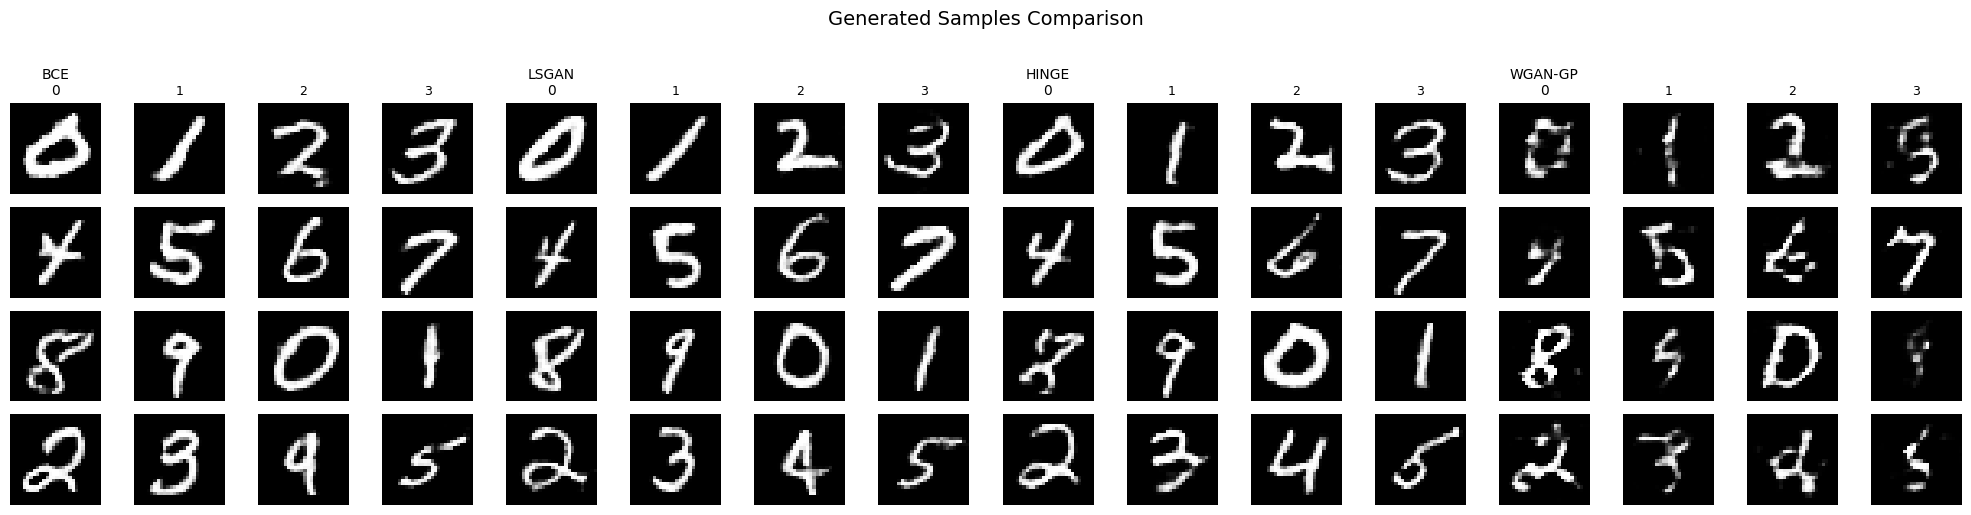

Saved: images/samples_comparison.png


In [17]:
# Generated Samples Comparison Grid

def plot_samples_comparison(results):
    """Show final generated samples from each strategy side by side."""
    strategies = list(results.keys())
    n_strategies = len(strategies)
    
    fig, axes = plt.subplots(4, n_strategies * 4, figsize=(n_strategies * 5, 5))
    
    for col, strategy in enumerate(strategies):
        samples = results[strategy]['final_samples']
        labels = results[strategy]['labels_test']
        
        for i in range(16):
            row = i // 4
            sub_col = i % 4
            ax = axes[row, col * 4 + sub_col]
            
            img = samples[i].numpy().reshape(28, 28)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            
            # Add strategy name as title for first row
            if i == 0:
                ax.set_title(f'{strategy.upper()}\n{labels[i].item()}', fontsize=10)
            elif row == 0:
                ax.set_title(str(labels[i].item()), fontsize=9)
    
    fig.suptitle('Generated Samples Comparison', fontsize=14, y=1.02)
    plt.tight_layout()
    os.makedirs('images', exist_ok=True)
    plt.savefig('images/samples_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: images/samples_comparison.png")

plot_samples_comparison(benchmark_results)

In [18]:
# Optional: Export benchmark results to CSV

def export_results_csv(results, filename='benchmark_results.csv'):
    """Export benchmark results to CSV for further analysis."""
    import csv
    
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Strategy', 'FID', 'KID_Mean', 'KID_Std', 'Training_Time_Seconds'])
        
        for name, data in results.items():
            writer.writerow([
                name,
                f"{data['fid']:.4f}",
                f"{data['kid_mean']:.6f}",
                f"{data['kid_std']:.6f}",
                f"{data['training_time']:.2f}"
            ])
    
    print(f"Results exported to {filename}")

# export_results_csv(benchmark_results)

# 8. Per-class Grid

---

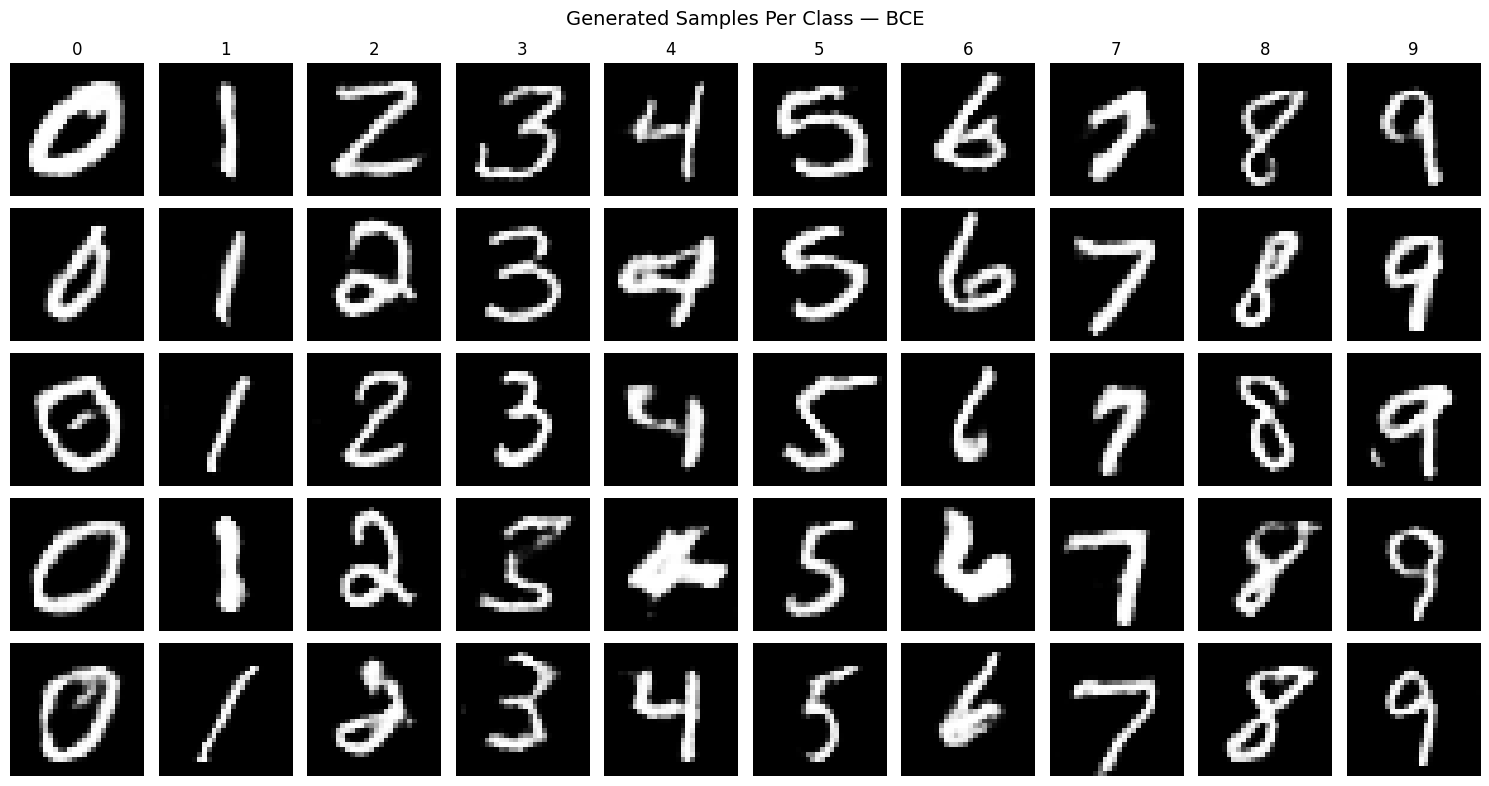

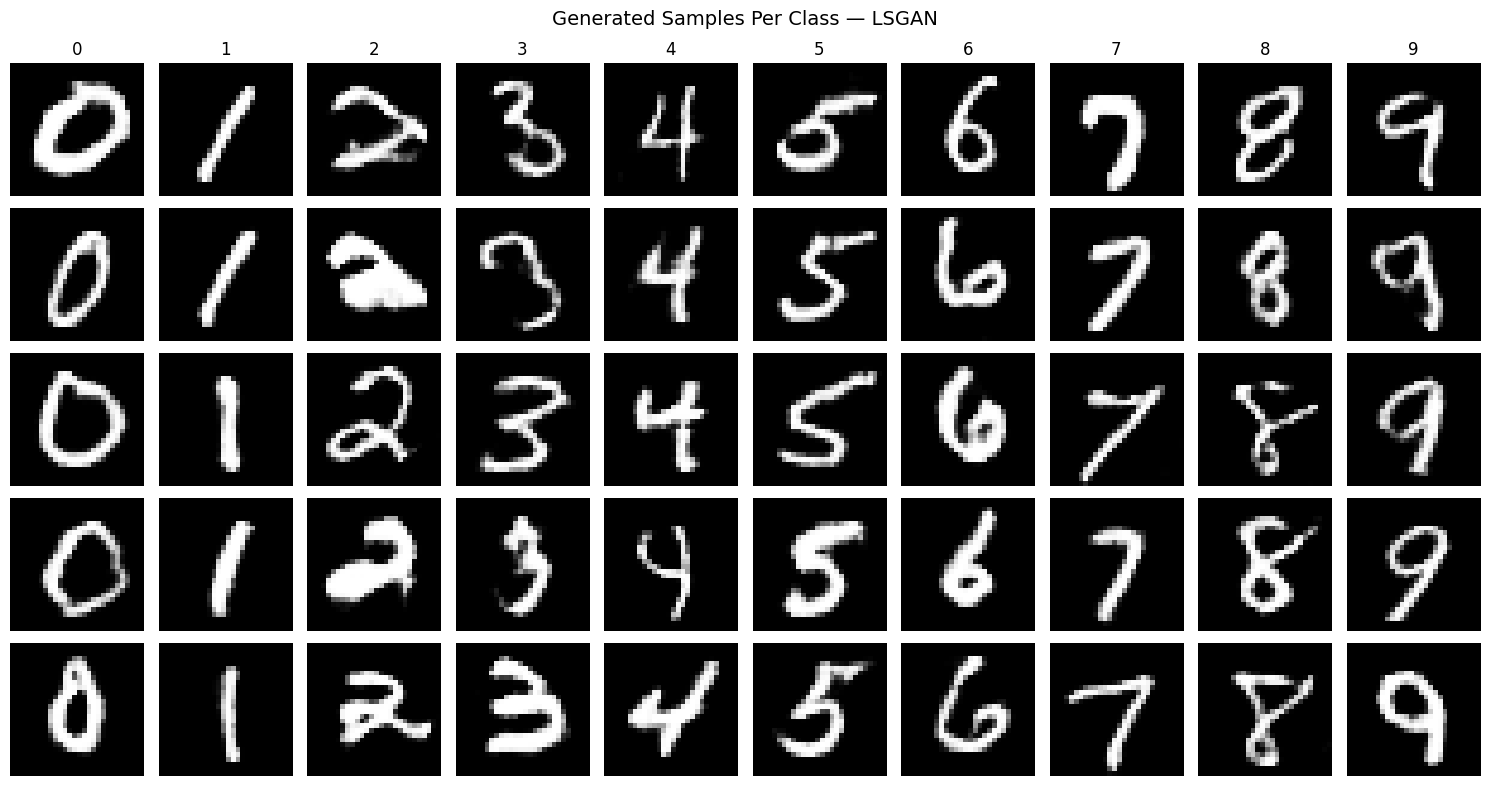

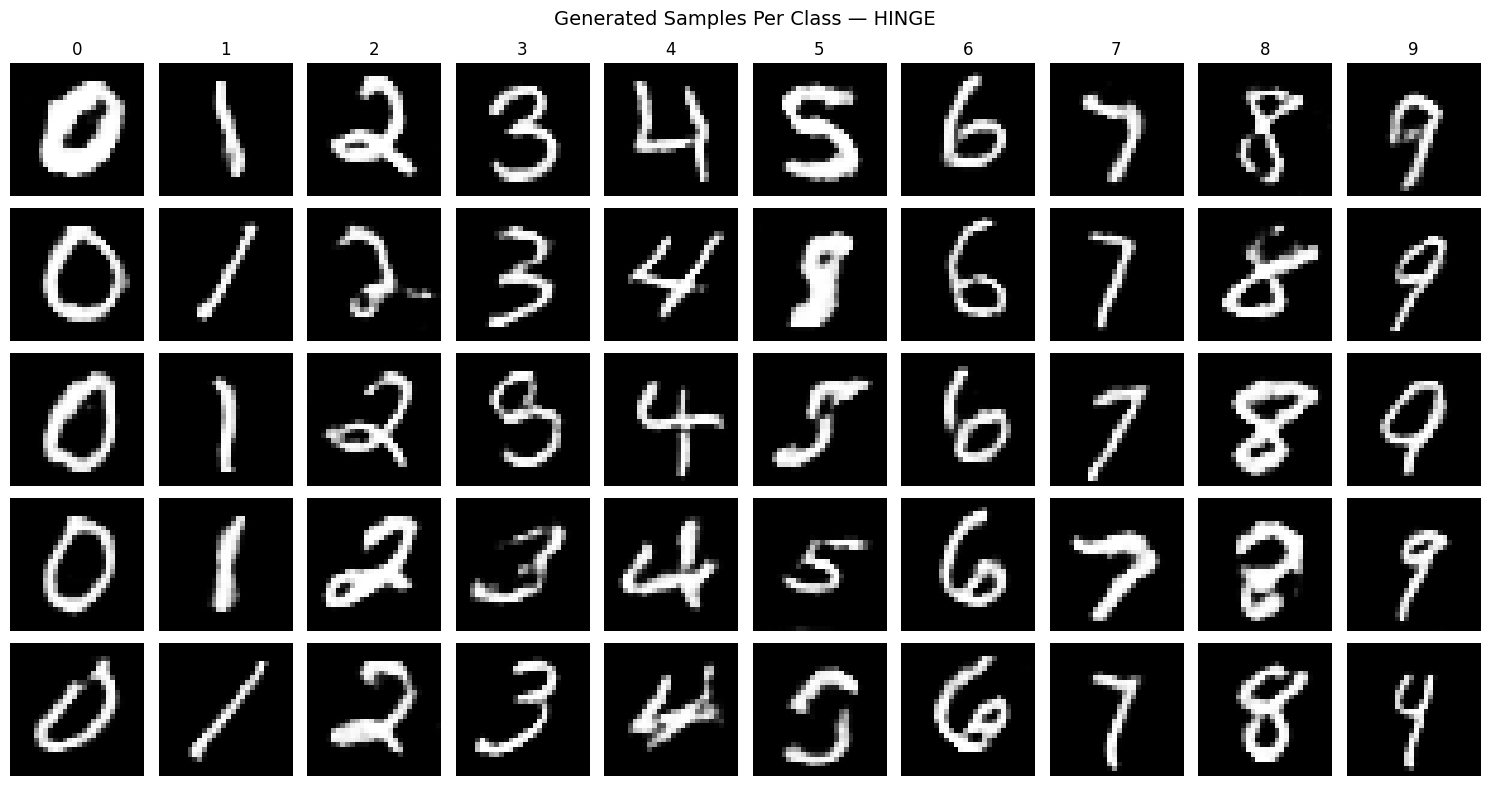

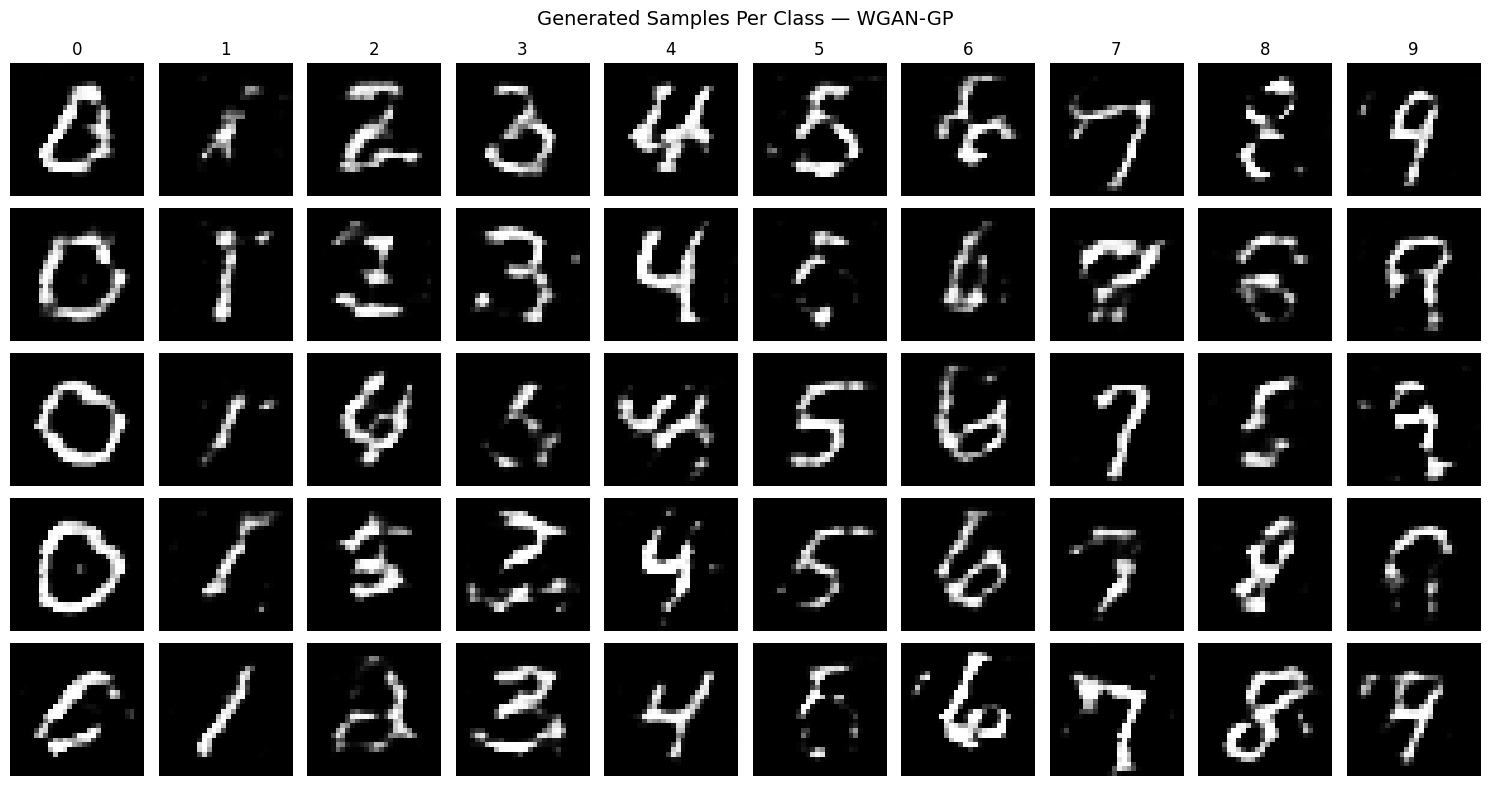

In [19]:
def plot_per_class(g_model, rows_per_class=5, title="Generated Samples Per Class"):
    """Generates a grid with one column per digit class (0-9)."""
    fig, axes = plt.subplots(rows_per_class, 10, figsize=(15, 8))

    for digit in range(10):
        noise = torch.randn(rows_per_class, LATENT_DIM, device=device)
        labels = torch.full((rows_per_class,), digit, device=device).long()  # shape: [B]

        with torch.no_grad():
            images = g_model(noise, labels)

        for row in range(rows_per_class):
            img = images[row].cpu().numpy().reshape(28, 28)
            axes[row, digit].imshow(img, cmap='gray')
            axes[row, digit].axis('off')

            if row == 0:
                axes[row, digit].set_title(str(digit))

    fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    plt.show()


# Plot for all strategies
for strategy_name in benchmark_results:
    g_model = Generator().to(device)
    g_model.load_state_dict(benchmark_results[strategy_name]['g_model_state'])
    g_model.eval()
    
    plot_per_class(g_model, title=f"Generated Samples Per Class — {strategy_name.upper()}")

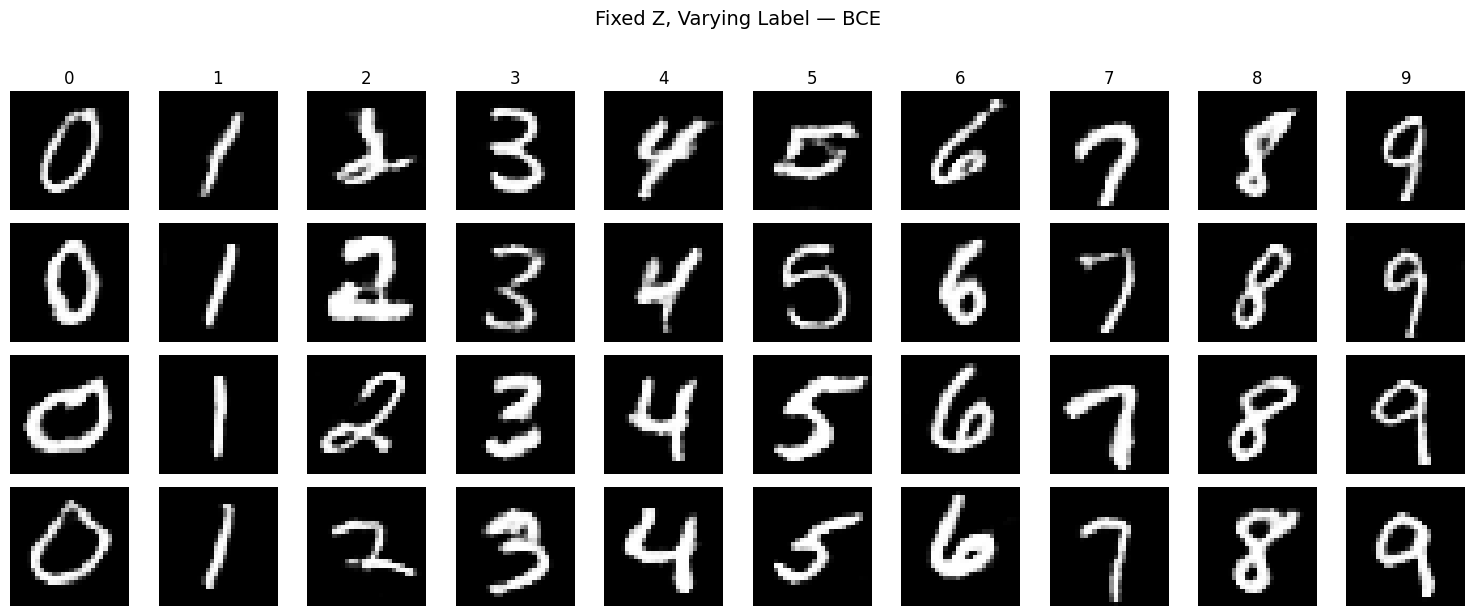

Saved: images/fixed_z_varying_label.png


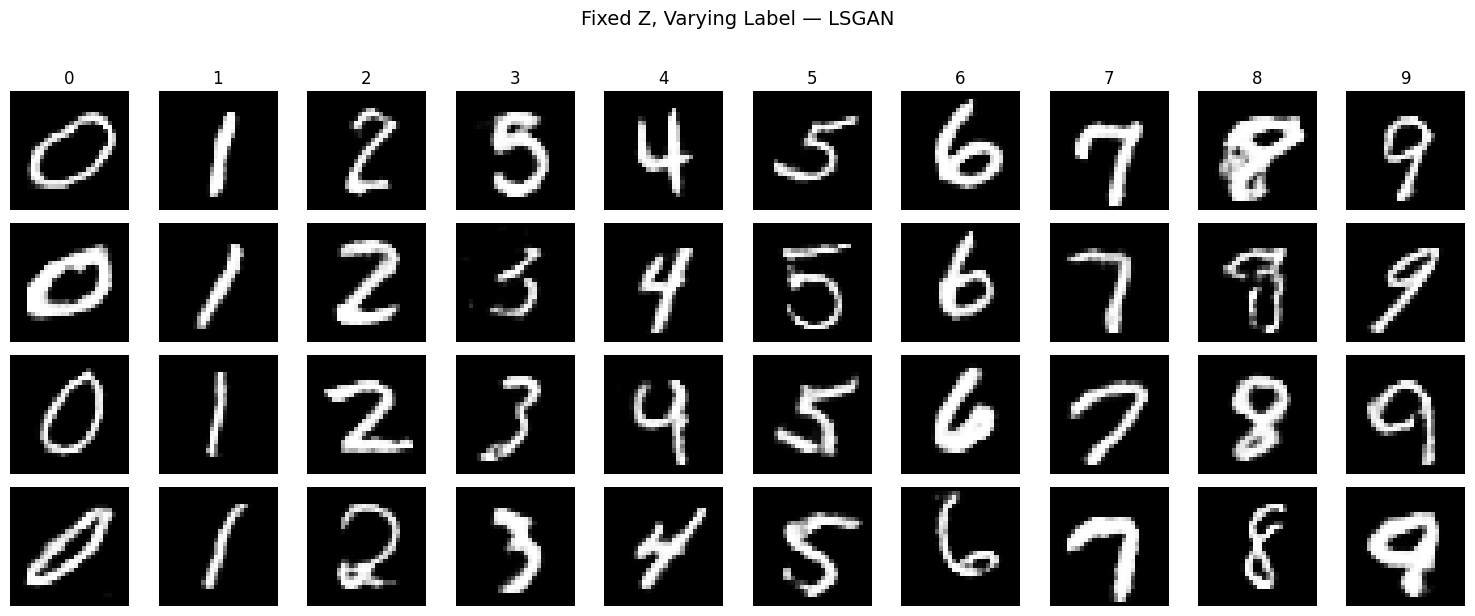

Saved: images/fixed_z_varying_label.png


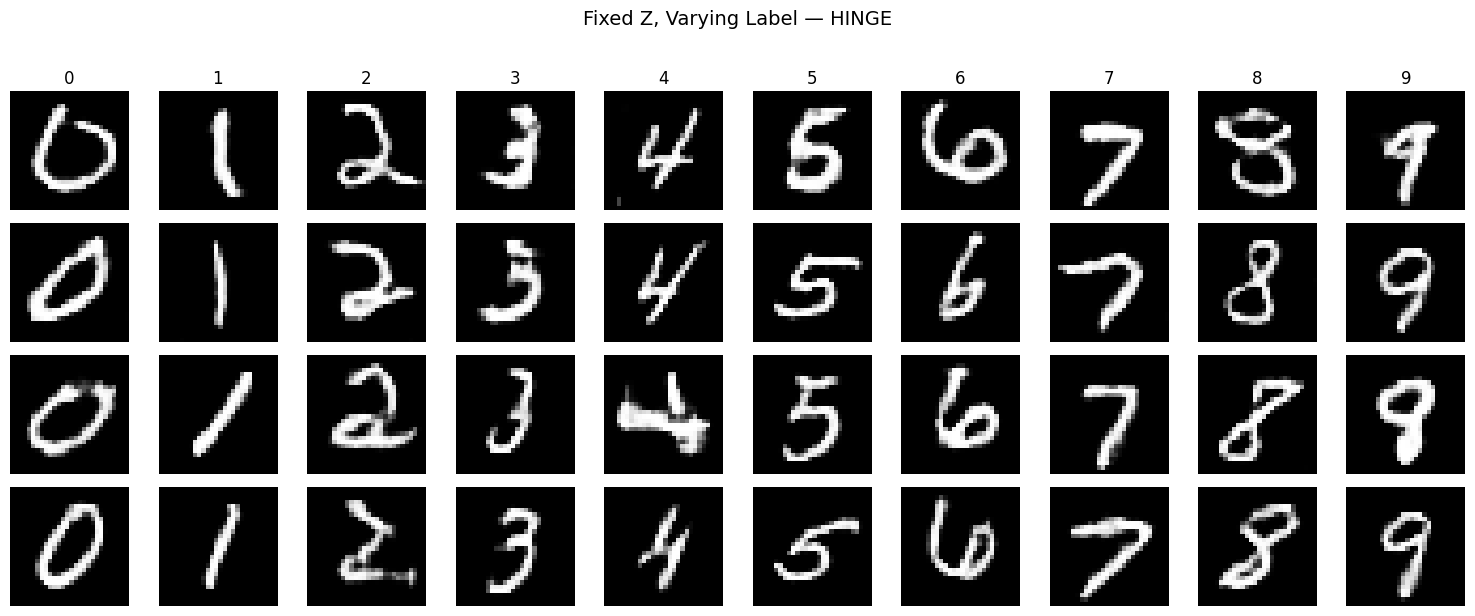

Saved: images/fixed_z_varying_label.png


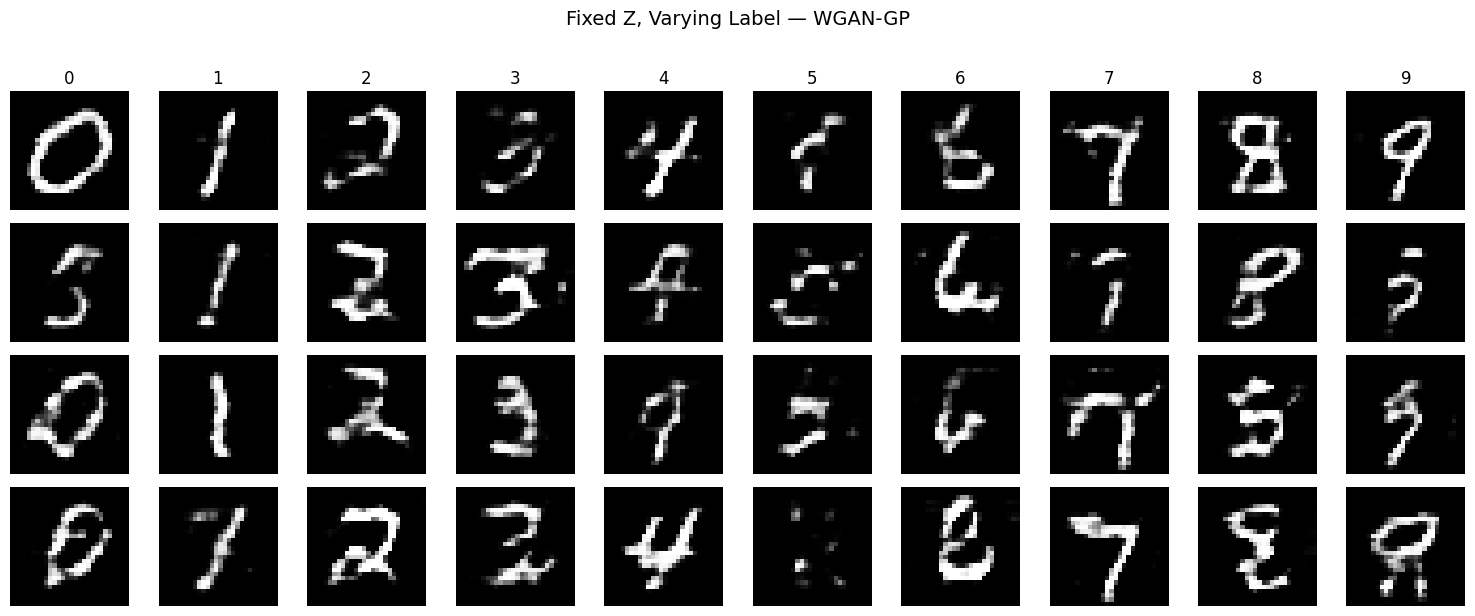

Saved: images/fixed_z_varying_label.png


In [22]:
# =============================================================================
# Fixed Z, Varying Label Visualization
# =============================================================================
# Demonstrates controllability: same noise vector produces different digits
# when conditioned on different labels.

def plot_fixed_z_varying_label(g_model, n_rows=4, title="Fixed Z, Varying Label (0-9)"):
    """
    Generate images using fixed noise vectors but varying labels.
    Each row uses the same z, columns show digits 0-9.
    
    This visually demonstrates that the cGAN has learned to use the label
    to control which digit is generated, independent of the noise vector.
    """
    g_model.eval()
    
    fig, axes = plt.subplots(n_rows, 10, figsize=(15, n_rows * 1.5))
    
    with torch.no_grad():
        for row in range(n_rows):
            # Fix one noise vector for this row
            fixed_z = torch.randn(1, LATENT_DIM, device=device)
            
            for digit in range(10):
                label = torch.tensor([digit], device=device).long()
                
                # Generate with fixed z, varying label
                sample = g_model(fixed_z, label)
                
                img = sample[0].cpu().numpy().reshape(28, 28)
                axes[row, digit].imshow(img, cmap='gray')
                axes[row, digit].axis('off')
                
                # Column headers (digit labels)
                if row == 0:
                    axes[row, digit].set_title(str(digit), fontsize=12)
            
            # Row label
            axes[row, 0].set_ylabel(f'z_{row+1}', fontsize=10, rotation=0, labelpad=20)
    
    fig.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    os.makedirs('images', exist_ok=True)
    plt.savefig('images/fixed_z_varying_label.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: images/fixed_z_varying_label.png")


# Plot for all strategies
for strategy_name in benchmark_results:
    g_model = Generator().to(device)
    g_model.load_state_dict(benchmark_results[strategy_name]['g_model_state'])
    g_model.eval()
    
    plot_fixed_z_varying_label(g_model, n_rows=4, title=f"Fixed Z, Varying Label — {strategy_name.upper()}")

# 10. Model Saving

---

In [20]:
def save_models(results):
    """Saves generator and discriminator state dicts for all strategies."""
    os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)
    
    for strategy_name, data in results.items():
        g_path = os.path.join(MODEL_OUTPUT_PATH, f'G_{strategy_name}.pt')
        d_path = os.path.join(MODEL_OUTPUT_PATH, f'D_{strategy_name}.pt')
        
        torch.save(data['g_model_state'], g_path)
        torch.save(data['d_model_state'], d_path)
        
        print(f"Saved: {g_path}, {d_path}")

save_models(benchmark_results)

Saved: model/G_bce.pt, model/D_bce.pt
Saved: model/G_lsgan.pt, model/D_lsgan.pt
Saved: model/G_hinge.pt, model/D_hinge.pt
Saved: model/G_wgan-gp.pt, model/D_wgan-gp.pt


# 11. Single-Image Inference

---

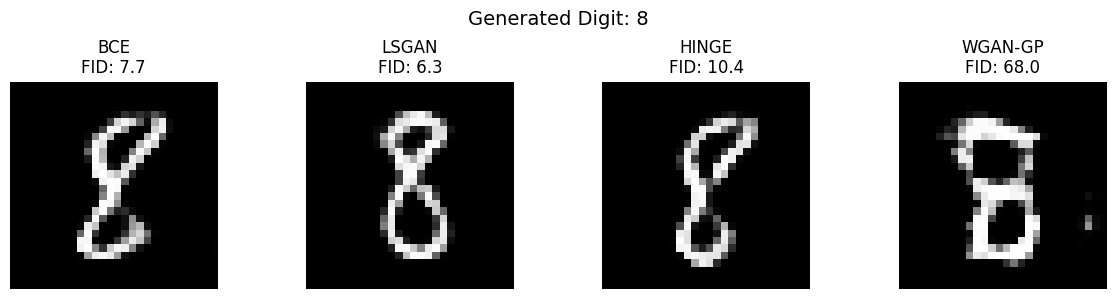

In [21]:
# Specify a digit from 0-9
digit = 8

# Use same noise for fair comparison
z = torch.randn(1, LATENT_DIM, device=device)
label = torch.tensor([[digit]], device=device)

fig, axes = plt.subplots(1, len(benchmark_results), figsize=(3 * len(benchmark_results), 3))

for idx, (strategy_name, data) in enumerate(benchmark_results.items()):
    g_model = Generator().to(device)
    g_model.load_state_dict(data['g_model_state'])
    g_model.eval()
    
    with torch.no_grad():
        generated = g_model(z, label)
    
    img = generated[0].cpu().numpy().reshape(28, 28)
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f"{strategy_name.upper()}\nFID: {data['fid']:.1f}")
    axes[idx].axis('off')

fig.suptitle(f"Generated Digit: {digit}", fontsize=14)
plt.tight_layout()
plt.show()